In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Пути к исходным данным
dataset_path = "dataset"
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")

# Создаем папки для train и val
os.makedirs(os.path.join(images_path, "train"), exist_ok=True)
os.makedirs(os.path.join(images_path, "val"), exist_ok=True)
os.makedirs(os.path.join(labels_path, "train"), exist_ok=True)
os.makedirs(os.path.join(labels_path, "val"), exist_ok=True)

# Получаем список всех изображений (без расширений)
image_files = [f.split('.')[0] for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Разделяем на train и val (80% train, 20% val)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Функция для перемещения файлов
def move_files(files, split_type):
    for file in files:
        # Перемещаем изображения
        for ext in ['.jpg', '.jpeg', '.png']:
            src_img = os.path.join(images_path, file + ext)
            if os.path.exists(src_img):
                dst_img = os.path.join(images_path, split_type, file + ext)
                shutil.move(src_img, dst_img)
                break
        
        # Перемещаем разметку
        src_label = os.path.join(labels_path, file + '.txt')
        if os.path.exists(src_label):
            dst_label = os.path.join(labels_path, split_type, file + '.txt')
            shutil.move(src_label, dst_label)

# Перемещаем файлы
move_files(train_files, "train")
move_files(val_files, "val")

print(f"Разделение завершено: {len(train_files)} train, {len(val_files)} val")

Разделение завершено: 40430 train, 10108 val


In [3]:
from ultralytics import YOLO
import torch
import cv2
import albumentations as A
from ultralytics import YOLO
from pathlib import Path
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from albumentations.pytorch import ToTensorV2

c:\Users\Ksenia\anaconda3\envs\nnenv_1\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def custom_augmentations():
    return A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.MotionBlur(blur_limit=7, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RandomRotate90(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

def apply_augmentation(image, bboxes, augmenter):
    labels = [0] * len(bboxes)
    augmented = augmenter(image=image, bboxes=bboxes, labels=labels)
    return augmented['image'], augmented['bboxes']

def save_augmented_data(image, bboxes, img_path, label_path):
    augmented_img_path = img_path.stem + '_aug.jpg'
    cv2.imwrite(str(Path(img_path.parent, augmented_img_path)), image)

    augmented_label_path = label_path.stem + '_aug.txt'
    with open(str(Path(label_path.parent, augmented_label_path)), 'w') as f:
        for bbox in bboxes:
            x_center, y_center, width, height = bbox
            f.write(f"0 {x_center} {y_center} {width} {height}\n")

In [ ]:
def augment_and_train(model, data_yaml, epochs=50, batch_size=8):
    augmenter = custom_augmentations()

    image_dir = Path('dataset/images/train')
    label_dir = Path('dataset/labels/train')

    for img_path in image_dir.glob("*.jpg"):
        label_path = label_dir / img_path.with_suffix(".txt").name

        image = cv2.imread(str(img_path))

        bboxes = []
        with open(str(label_path), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    bboxes.append([x, y, w, h])

        if not bboxes:
            continue

        augmented_image, augmented_bboxes = apply_augmentation(image, bboxes, augmenter)
        save_augmented_data(augmented_image, augmented_bboxes, img_path, label_path)

        train_results = model.train(
            data=data_yaml,
            epochs=epochs,
            imgsz=640,
            batch=batch_size,
            workers=2,
            device=1,
            optimizer='AdamW',
        )

In [2]:
def visualize_augmented_batch(images, bboxes_list, augmenter, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for idx, (image, bboxes) in enumerate(zip(images, bboxes_list)):
        if idx >= rows * cols:
            break

        aug_img, aug_bboxes = apply_augmentation(image, bboxes, augmenter)

        img_with_boxes = aug_img.copy()
        h, w = img_with_boxes.shape[:2]
        for (x_c, y_c, bw, bh) in aug_bboxes:
            x1 = int((x_c - bw / 2) * w)
            y1 = int((y_c - bh / 2) * h)
            x2 = int((x_c + bw / 2) * w)
            y2 = int((y_c + bh / 2) * h)
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')
        axes[idx].set_title(f"Aug {idx+1}")

    plt.tight_layout()
    plt.show()

In [29]:
augmenter = custom_augmentations()

img_paths = list(Path("dataset/images/train").glob("*.jpg"))[:10]
label_paths = [Path("dataset/labels/train") / (p.stem + ".txt") for p in img_paths]

images = [cv2.imread(str(p)) for p in img_paths]
bboxes_list = []
for lp in label_paths:
    bboxes = []
    with open(lp) as f:
        for line in f:
            if line.strip():
                _, x, y, w, h = line.strip().split()
                bboxes.append([float(x), float(y), float(w), float(h)])
    bboxes_list.append(bboxes)

In [30]:
def visualize_batch(images, bboxes_list, title="Images"):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axs = [axs]
    for img, bboxes, ax in zip(images, bboxes_list, axs):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        for box in bboxes:
            x, y, w, h = box
            h_img, w_img = img.shape[:2]
            x1 = (x - w / 2) * w_img
            y1 = (y - h / 2) * h_img
            rect_w = w * w_img
            rect_h = h * h_img
            rect = plt.Rectangle((x1, y1), rect_w, rect_h, edgecolor='r', facecolor='none', linewidth=2)
            ax.add_patch(rect)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

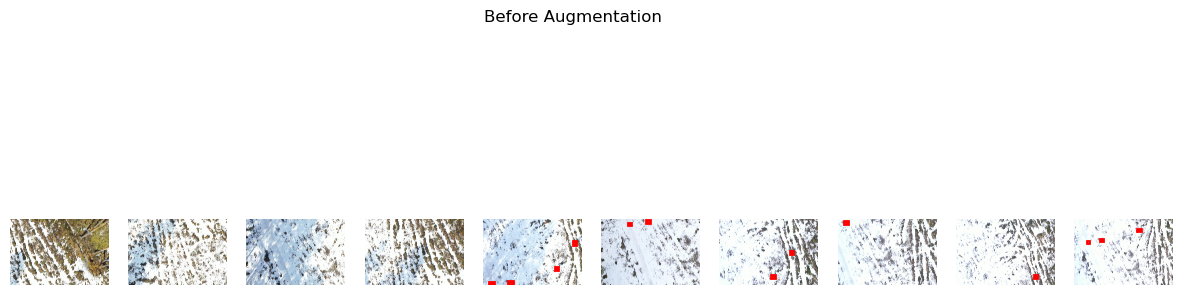

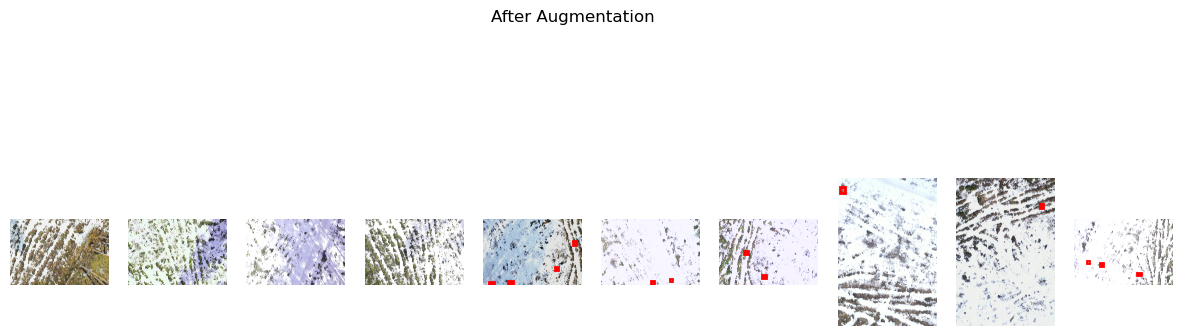

In [31]:
visualize_batch(images, bboxes_list, title="Before Augmentation")


labels_list = [[0] * len(boxes) for boxes in bboxes_list]

augmented = [
    augmenter(image=img, bboxes=boxes, labels=labels)
    for img, boxes, labels in zip(images, bboxes_list, labels_list)
]
aug_images = [a['image'] for a in augmented]
aug_bboxes = [a['bboxes'] for a in augmented]

visualize_batch(aug_images, aug_bboxes, title="After Augmentation")


In [ ]:
torch.cuda.is_available()

True

In [ ]:
model = YOLO("yolo11s.pt")
augment_and_train(model, data_yaml="dataset/data.yaml", epochs=50)